<a href="https://colab.research.google.com/github/waelrash1/predictive_analytics_DT302/blob/main/Stacking_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stacking: Ensamble models

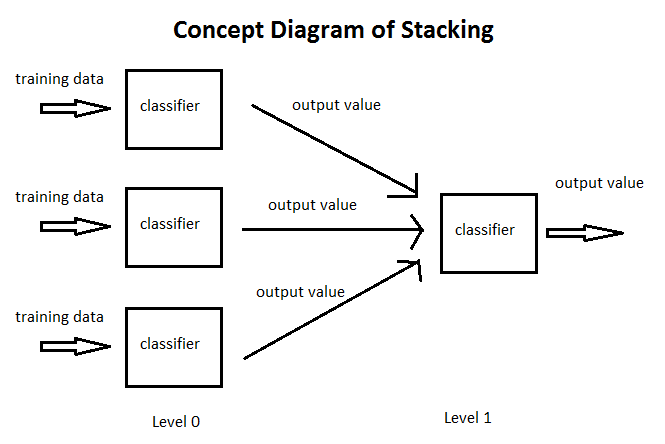



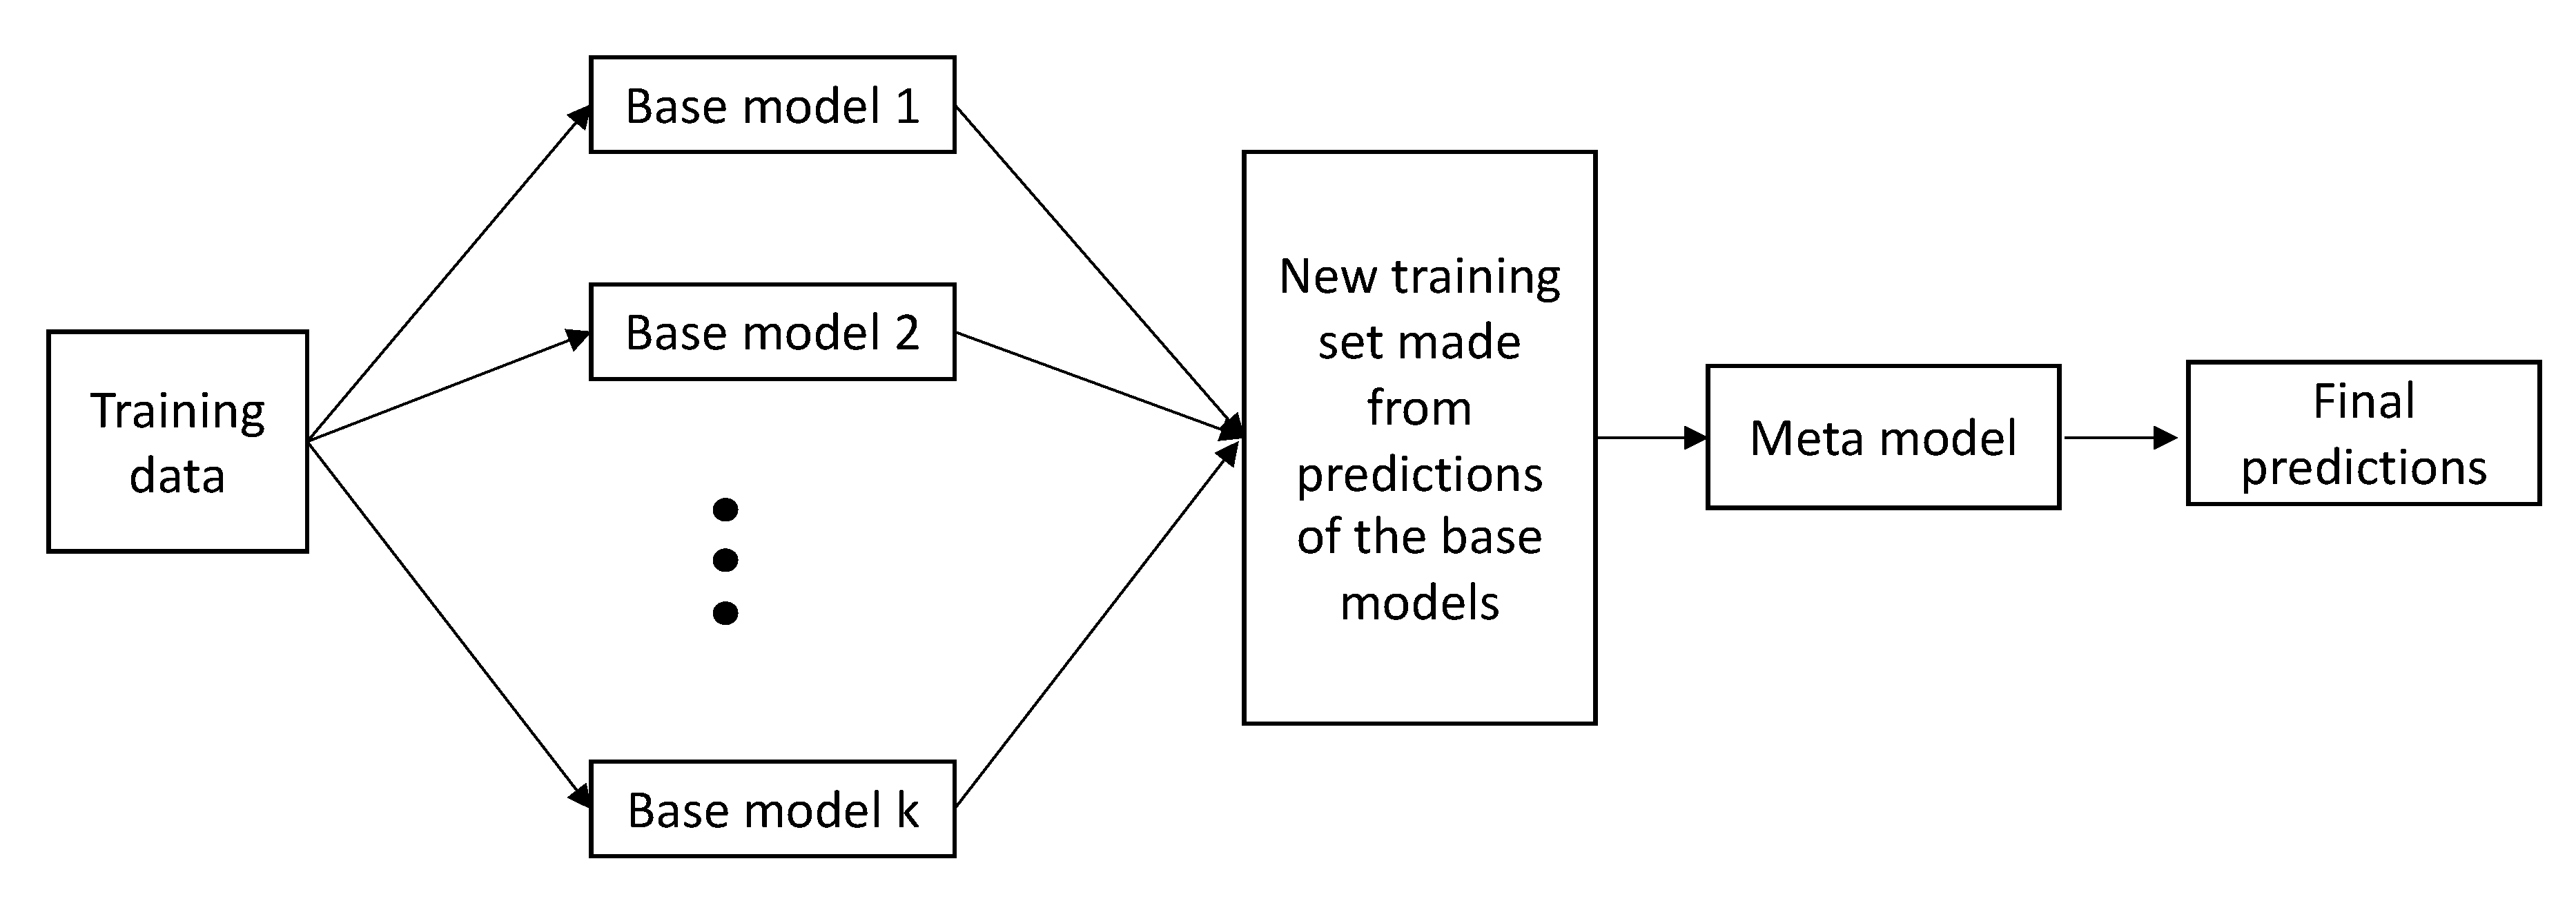

In [ ]:
%pip install mlxtend --upgrad

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
import pydot
from IPython.display import Image
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from six import StringIO 
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, r2_score
from mlxtend.regressor import StackingCVRegressor

In [ ]:
#loading data hitters.csv

url='https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv'
df = pd.read_csv(url).dropna()
df.info()
df.sample(5)

In [ ]:

y = np.log(df.Salary)
y=df.Salary
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
ridge_model_L1 = Ridge(alpha = .57,random_state=1 )
lass_model_L1 = Lasso( alpha = 2.4,max_iter = 10000,random_state=1)
rf_model_L1=RandomForestRegressor(random_state=1)
knn_model_L1=KNeighborsRegressor()
xgb_model_L1=XGBRegressor( silent=True,random_state=1)

xgb_model_L2=XGBRegressor(silent=True,random_state=1)

models=[ridge_model_L1,
        lass_model_L1,
        rf_model_L1,
        knn_model_L1,
       xgb_model_L1]


labels = ['Ridge Regression','Lasso Regression' , 'Random Forest', 'KNN Regression', 'XGB Regression']

In [ ]:
print('5-fold cross validation:\n')
for model, label in zip(models,labels):

    scores = cross_validate(model, X_train, y_train, 
                                              cv=5,scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True)
    print("R_squered: %0.2f (+/- %0.2f) [%s]"
          % (scores['test_r2'].mean(), scores['test_r2'].std(), "Mean_squared_error: %0.2f (+/- %0.2f) [%s]"
          % (-scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std(), label)))


In [ ]:

stack = StackingCVRegressor(regressors=models,
                            meta_regressor=xgb_model_L2, cv=10,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False
                           )

In [ ]:
stack.fit(X_train.values, y_train.values)
X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
                  'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18'] # Xgboost internally renames the features
pred = stack.predict(X_test.values)
score_mse = mean_squared_error(y_test, pred)
score_r2=r2_score(y_test, pred)*100
print('Model: {0}, MSE: {1}'.format(type(stack).__name__, score_mse))
print('Model: {0}, R2: {1}'.format(type(stack).__name__, score_r2))


## Another Example on classification

In [ ]:
%pip install vecstack

In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from vecstack import stacking

In [ ]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
names = ['Class', 'Alcohol', 'Malic acid', 'Ash',
         'Alcalinity of ash' ,'Magnesium', 'Total phenols',
         'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',     'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
         'Proline']
df = pd.read_csv(link, header=None, names=names)
df.sample(5)

In [ ]:
y = df[['Class']]
y.values.reshape(y.size,)
X = df.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
y.shape


In [ ]:
models = [
    KNeighborsClassifier(n_neighbors=5,
                        n_jobs=-1),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=3),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3)
]

In [ ]:
S_train, S_test = stacking(models,                   
                           X_train, y_train.values.ravel(), X_test,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

The stacking function takes several inputs:
* models: the first level models we defined earlier
* X_train, y_train, X_test: our data
* regression: Boolean indicating whether we want to use the function for regression. In our case set to False since this is a classification
* mode: using the earlier describe out-of-fold during cross-validation
* needs_proba: Boolean indicating whether you need the probabilities of class labels
* save_dir: save the result to directory Boolean
metric: what evaluation metric to use (we imported the accuracy_score in the beginning)
* n_folds: how many folds to use for cross-validation
* stratified: whether to use stratified cross-validation
* shuffle: whether to shuffle the data
* random_state: setting a random state for reproducibility
* verbose: 2 here refers to printing all info


In [ ]:
model = XGBClassifier(random_state=0,silent=True)
    
model = model.fit(S_train, y_train.values.ravel())
y_pred = model.predict(S_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

In [ ]:
model =RandomForestClassifier(random_state=0, n_jobs=-1)
    
model = model.fit(S_train, y_train.values.ravel())
y_pred = model.predict(S_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))